# Solar Sunspot Prediction 

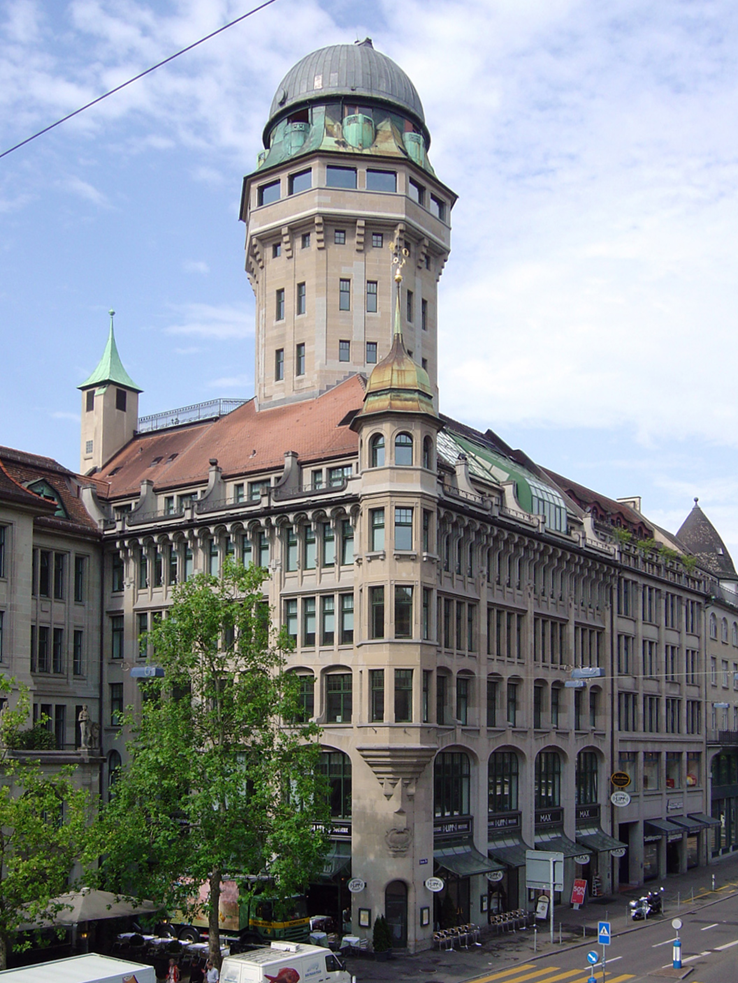

https://en.wikipedia.org/wiki/Urania_Sternwarte


## Introduction

This project was made for the purpose of being a graded assignment for DSCI 311 at the University of Oregon, Fall Term 2024. 
The code contained within is written by Henry Gipson for the purpose of the assignment. 

The data was sourced via the following link: 

https://www.kaggle.com/datasets/abhinand05/daily-sun-spot-data-1818-to-2019/data

All python modules used are open source and can be found via the following links to their documentation

- CSV : https://docs.python.org/3/library/csv.html
- Matplotlib : https://matplotlib.org/
    -Pyplot : https://matplotlib.org/stable/api/pyplot_summary.html
- Numpy : https://numpy.org/
- Pandas : https://pandas.pydata.org/
- Re : https://docs.python.org/3/library/re.html
- Seaborn : https://seaborn.pydata.org/
- Scipy : https://scipy.org/
    - Optimize : https://docs.scipy.org/doc/scipy/tutorial/optimize.html
        - Curve Fit : https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
    - Signal : https://docs.scipy.org/doc/scipy/reference/signal.html
        - Find Peaks : https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
- SK Learn : https://scikit-learn.org/stable/index.html
    - Ensemble : https://scikit-learn.org/stable/modules/ensemble.html
        - Random Forest Regressor : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
    - Linear Model : https://scikit-learn.org/stable/api/sklearn.linear_model.html
        - Linear Regression : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
    - Metrics : https://scikit-learn.org/stable/modules/model_evaluation.html
        - MAE : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
        - MSE : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    - Model Selection : https://scikit-learn.org/stable/api/sklearn.model_selection.html 
        - Train Test Split : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split

This Project looks to use Data Analytics to explore and predict sunspot counts based on trends. 
        

#### The Data

Data description as provided by Kaggle :
Daily total sunspot number derived by the formula: R= Ns + 10 * Ng, with Ns the number of spots and Ng the number of groups counted over the entire solar disk.

No daily data are provided before 1818 because daily observations become too sparse in earlier years. Therefore, R. Wolf only compiled monthly means and yearly means for all years before 1818.

In the TXT and CSV files, the missing values are marked by -1 (valid Sunspot Number are always positive).

New scale:
The conventional 0.6 Zürich scale factor is not used anymore and A. Wolfer (Wolf's successor) is now defining the scale of the entire series. This puts the Sunspot Number at the scale of raw modern counts, instead of reducing it to the level of early counts by R. Wolf.

Error values:
Those values correspond to the standard deviation of raw numbers provided by all stations. Before 1981, the errors are estimated with the help of an auto-regressive model based on the Poissonian distribution of actual Sunspot Numbers. From 1981 onwards, the error value is the actual standard deviation of the sample of raw observations used to compute the daily value.
The standard error of the daily Sunspot Number can be computed by:
sigma/sqrt(N) where sigma is the listed standard deviation and N the number of observations for the day.
Before 1981, the number of observations is set to 1, as the Sunspot Number was then essentially the raw Wolf number from the Zürich Observatory.

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
sunspot = pd.read_csv('sunspot_data.csv')
sunspot

,Unnamed: 0,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
0,0,1818,1,1,1818.001,-1,-1.0,0,1
1,1,1818,1,2,1818.004,-1,-1.0,0,1
2,2,1818,1,3,1818.007,-1,-1.0,0,1
3,3,1818,1,4,1818.010,-1,-1.0,0,1
4,4,1818,1,5,1818.012,-1,-1.0,0,1
...,...,...,...,...,...,...,...,...,...
73713,73713,2019,10,27,2019.821,0,0.0,34,0
73714,73714,2019,10,28,2019.823,0,0.0,34,0
73715,73715,2019,10,29,2019.826,0,0.0,30,0
73716,73716,2019,10,30,2019.829,0,0.0,24,0


## EDA

To Start, I am going explore our data using EDA, the following code documents my process

First Impressions is that there is a significant of data, but we should format things a bit better, 

In [3]:
sunspot = sunspot[['Year','Month','Day','Number of Sunspots','Standard Deviation','Observations','Indicator']]
sunspot.head()

,Year,Month,Day,Number of Sunspots,Standard Deviation,Observations,Indicator
0,1818,1,1,-1,-1.0,0,1
1,1818,1,2,-1,-1.0,0,1
2,1818,1,3,-1,-1.0,0,1
3,1818,1,4,-1,-1.0,0,1
4,1818,1,5,-1,-1.0,0,1


My eventual goal is to take a machine learning algorithm and attempt to predict the number of daily sunspots in the last year, I will then compare against the actual data from that time period. As such any values that show up as -1 (missing data) are not going to be helpful for this process so i'll filter them out

In [4]:
sunspot_valid = sunspot[sunspot['Number of Sunspots'] >= 0]
sunspot_valid.head()

,Year,Month,Day,Number of Sunspots,Standard Deviation,Observations,Indicator
7,1818,1,8,65,10.2,1,1
12,1818,1,13,37,7.7,1,1
16,1818,1,17,77,11.1,1,1
17,1818,1,18,98,12.6,1,1
18,1818,1,19,105,13.0,1,1


I also find that the Year, Month, and Day, columns don't need to be split as such, I'll convert those three columns in to a single datetime column

In [5]:
sunspot_valid = sunspot_valid.copy()

sunspot_valid['Date'] = pd.to_datetime(sunspot_valid[['Year', 'Month', 'Day']])
sunspot_valid.drop(columns=['Year', 'Month', 'Day'], inplace=True)
sunspot_valid.head()

,Number of Sunspots,Standard Deviation,Observations,Indicator,Date
7,65,10.2,1,1,1818-01-08
12,37,7.7,1,1,1818-01-13
16,77,11.1,1,1,1818-01-17
17,98,12.6,1,1,1818-01-18
18,105,13.0,1,1,1818-01-19


And then Ill reorder the columns 

In [6]:
sunspot_clean = sunspot_valid[['Date','Number of Sunspots','Standard Deviation','Observations','Indicator']]
sunspot_clean.describe()

,Date,Number of Sunspots,Standard Deviation,Observations,Indicator
count,70471,70471.000000,70471.000000,70471.000000,70471.000000
mean,1922-10-25 02:19:26.471314432,82.946247,7.289718,4.633778,0.998255
min,1818-01-08 00:00:00,0.000000,0.000000,1.000000,0.000000
25%,1875-02-15 12:00:00,21.000000,3.500000,1.000000,1.000000
50%,1923-05-13 00:00:00,63.000000,6.800000,1.000000,1.000000
75%,1971-08-06 12:00:00,127.000000,10.200000,1.000000,1.000000
max,2019-10-31 00:00:00,528.000000,77.700000,60.000000,1.000000
std,NaN,77.252109,4.567518,8.004843,0.041742


Im also going to explore these visually

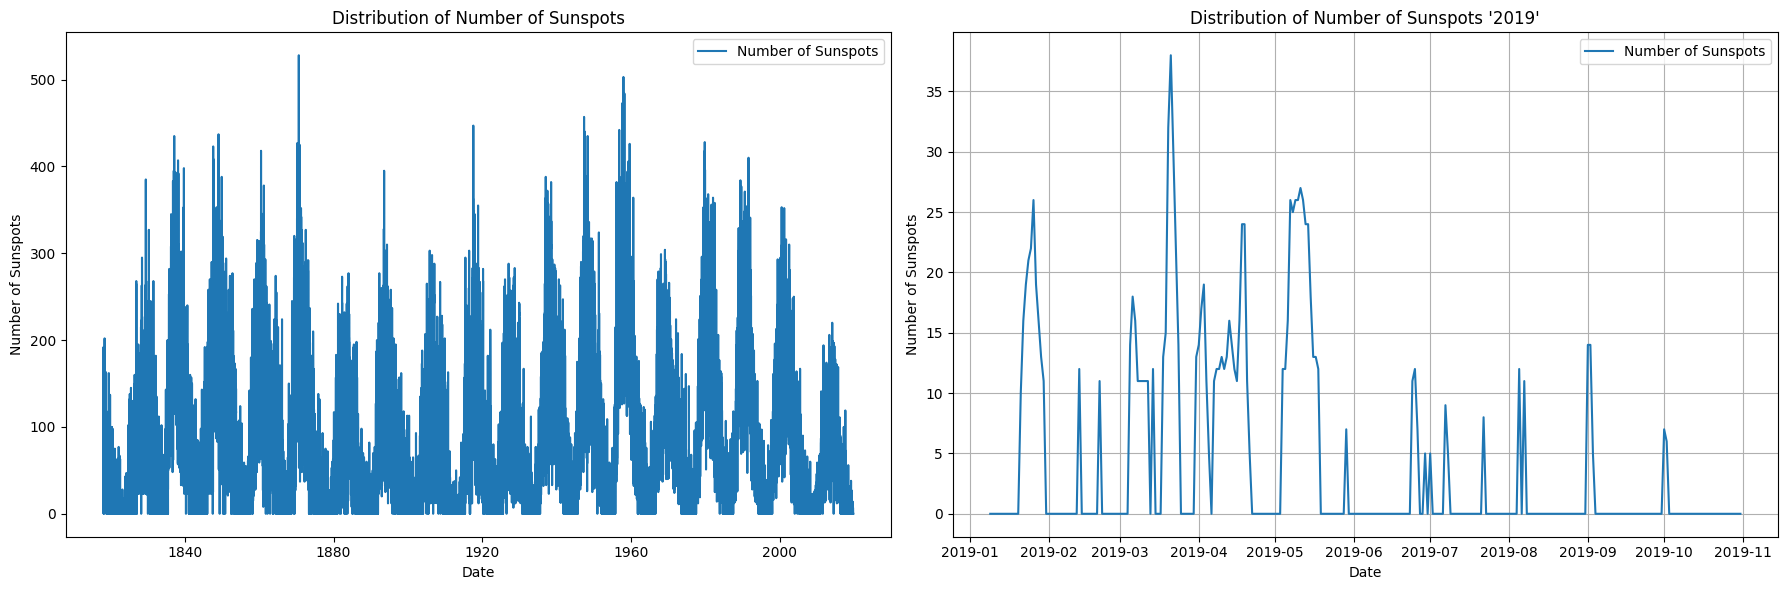

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.lineplot(x =sunspot_clean['Date'], y = sunspot_clean['Number of Sunspots'], label='Number of Sunspots',ax=axes[0])
axes[0].set_title('Distribution of Number of Sunspots')
plt.xlabel('Date')
plt.ylabel('Number of Sunspots')
plt.grid(True)

parse = sunspot_clean[sunspot_clean['Date'] > '2019-01-08']
sns.lineplot(x = parse['Date'], y = parse['Number of Sunspots'], label='Number of Sunspots',ax=axes[1])
axes[1].set_title("Distribution of Number of Sunspots '2019'")
plt.xlabel('Date')
plt.ylabel('Number of Sunspots')
plt.grid(True)

plt.tight_layout()
plt.show()

My first pass of EDA only included the first plot, but after further analysis adding a focused, one year plot, helps to better see the data

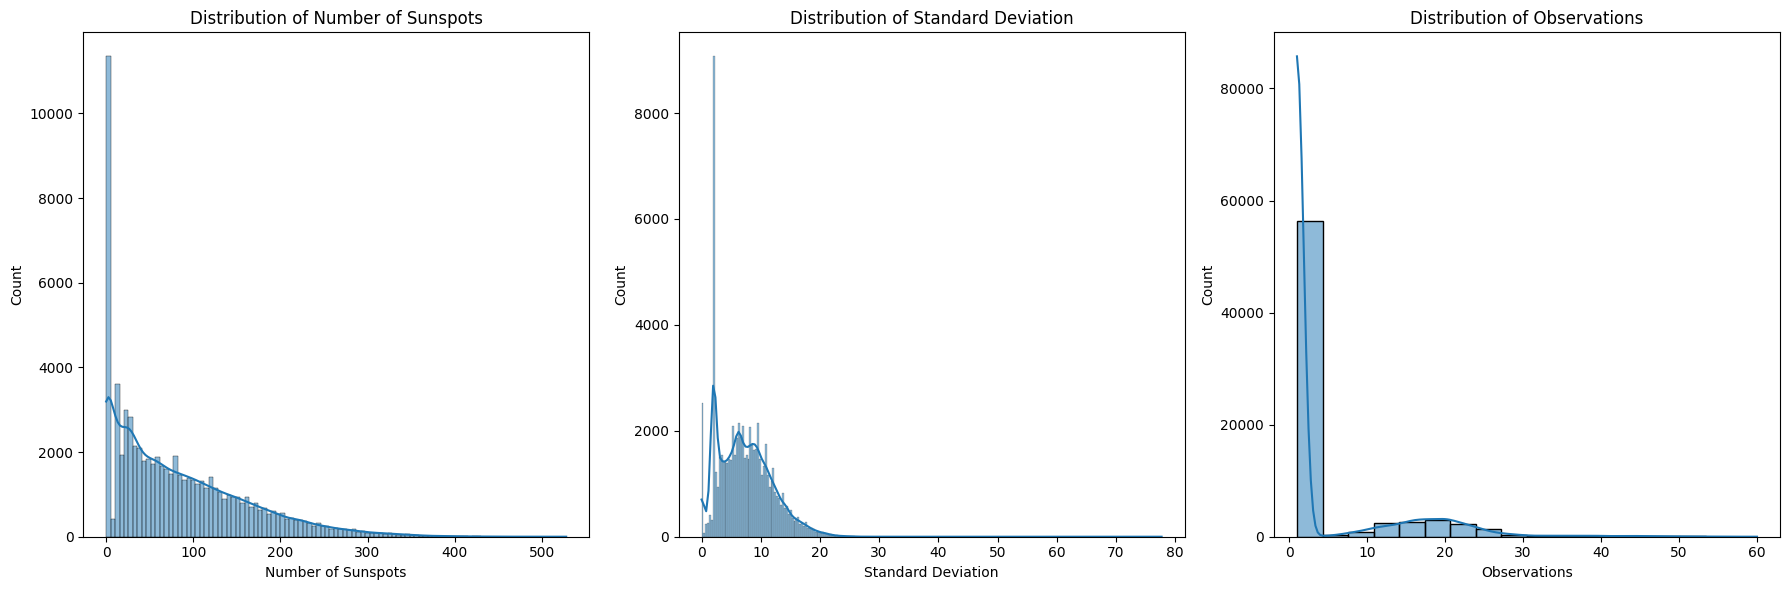

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(sunspot_clean['Number of Sunspots'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Number of Sunspots')

sns.histplot(sunspot_clean['Standard Deviation'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Standard Deviation')

sns.histplot(sunspot_clean['Observations'], kde=True, ax=axes[2])
axes[2].set_title('Distribution of Observations')

plt.tight_layout()
plt.show()

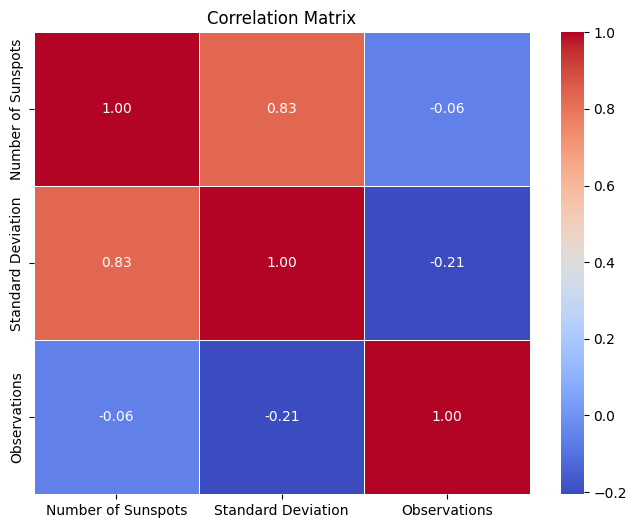

In [9]:
correlation_matrix = sunspot_clean[['Number of Sunspots', 'Standard Deviation', 'Observations']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

After the correlation matrix above it seems that most of the data remains fairly uncorrelated except for the number of sunspots and the standard deviation. it seemed worthwhile to attempt some sort of machine learning model to look further into this. The below code defines this process using SK-Learn's Linear Regression Model

In [23]:
features = ['Standard Deviation', 'Observations']  
X = sunspot_clean[features]
y = sunspot_clean['Number of Sunspots']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model

LinearRegression()

In [24]:

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 1737.9334605350675
R-squared: 0.7100637595761234


## Inference


From this data and more importantly the correlation matrix and R-squared values. It seems that with the given data we should have the reasonable chance of somewhat predicting the number of given sunspots, but that a linear regression model would be the incorrect way of approaching it. What I suspect from the line plot is that we could group sections of our data into clusters to predict the outcome of the next cluster (almost like a cyclical pattern) and will be my focus of my efforts going forward.

To further prove this hypothesis the following code attempt to model a sinusoldal wave to my data, using Least Squares Regression. The goal is to prove that this is the incorrect model to use and that some sort of grouping might be needed. the equation to fit these waves to is $$y=A_1  sin(ωx)+A_2  cos(ωx)+C$$
This equation represents the linear form of a sin wave, however our period $ω$ needs to be determined first

In [11]:
sunspot_clean['Date'] = pd.to_datetime(sunspot_clean['Date'])
sunspot_clean['NumericDate'] = (sunspot_clean['Date'] - sunspot_clean['Date'].min()).dt.days

The code below takes advantage of SciPy's `find_peaks` function to help process the data

In [12]:
sunspots_array = sunspot_clean['Number of Sunspots'].values

peaks, _ = find_peaks(sunspots_array, distance=200)
peak_dates = sunspot_clean.iloc[peaks]['NumericDate']
period_estimate = peak_dates.diff().mean()

print(f"Estimated Period: {period_estimate} days")


Estimated Period: 274.7003745318352 days


Once we have determined the period of the sin wave we can attempt to fit, we can then use a curve fitting algorithm like SciPy's `curve_fit` to find the best parameters to plot our function

In [13]:
def sinusoidal_model(x, A1, A2, C, omega):
    return A1 * np.sin(omega * x) + A2 * np.cos(omega * x) + C

omega_initial = 2 * np.pi / period_estimate  
initial_guess = [100, 100, 100, omega_initial]

x_data = sunspot_clean['NumericDate'].values
y_data = sunspot_clean['Number of Sunspots'].values

params, _ = curve_fit(sinusoidal_model, x_data, y_data, p0=initial_guess)

A1, A2, C, omega = params
print(f"Fitted Parameters: A1 = {A1}, A2 = {A2}, C = {C}, omega = {omega}")

amplitude = np.sqrt(A1**2 + A2**2)
phase = np.arctan2(A2, A1)
print(f"Amplitude: {amplitude}, Phase: {phase}")


Fitted Parameters: A1 = 1.6207489452986854, A2 = 0.16069248866082234, C = 82.9470753756792, omega = 0.02285135780185605
Amplitude: 1.6286955576776188, Phase: 0.09882408371419825


Now with the determined parameters we can fit the sine wave to our data and plot our results

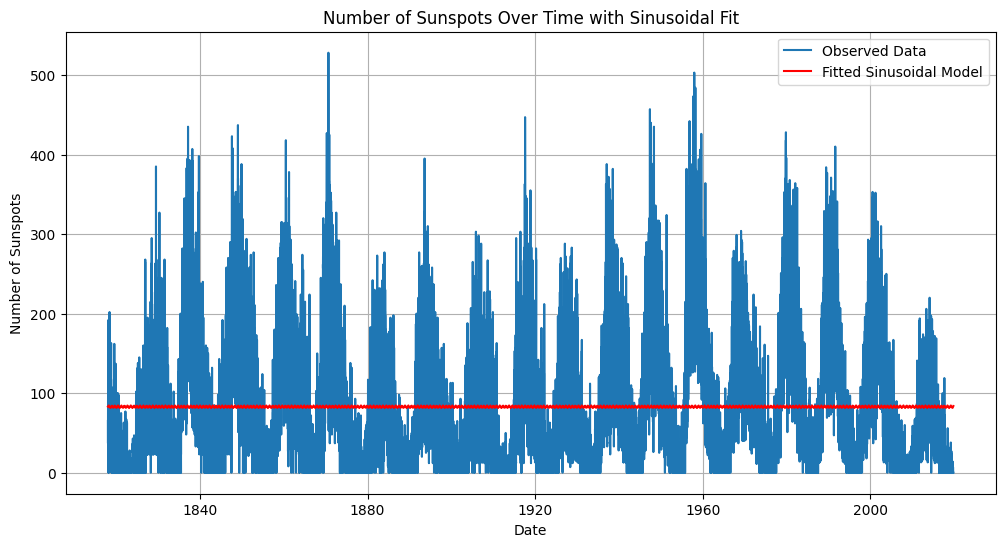

In [14]:
x_fit = np.linspace(x_data.min(), x_data.max(), 1000)  
y_fit = sinusoidal_model(x_fit, *params)

plt.figure(figsize=(12, 6))
sns.lineplot(x=sunspot_clean['Date'], y=sunspot_clean['Number of Sunspots'], label='Observed Data')
sns.lineplot(x=pd.to_datetime(sunspot_clean['Date'].min()) + pd.to_timedelta(x_fit, unit='D'),y=y_fit, label='Fitted Sinusoidal Model', color='red')


plt.title('Number of Sunspots Over Time with Sinusoidal Fit')
plt.xlabel('Date')
plt.ylabel('Number of Sunspots')
plt.legend()
plt.grid(True)


plt.show()

And as predicted this does not look quite right, like in EDA I'll isolate just 2019 for a closer look

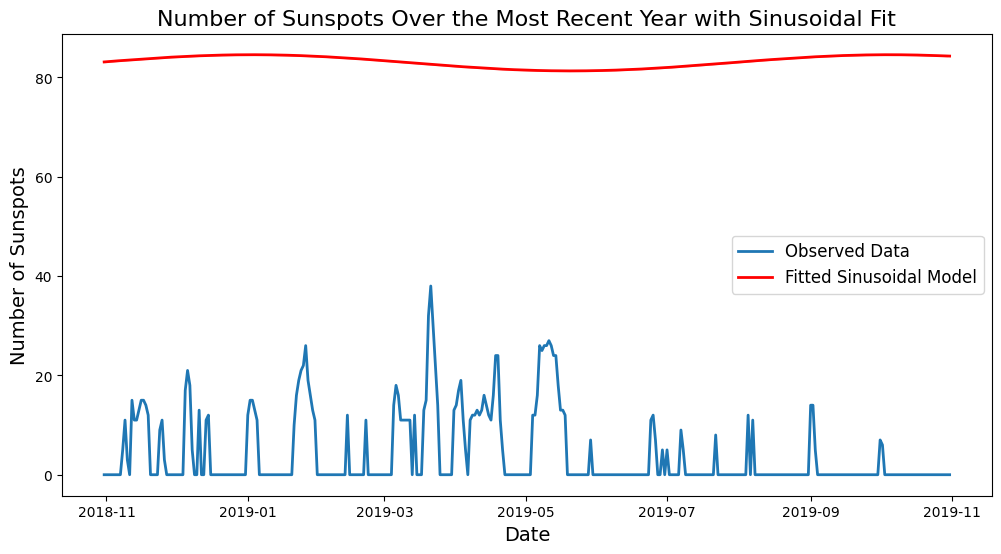

In [15]:
most_recent_date = sunspot_clean['Date'].max()
one_year_ago = most_recent_date - pd.Timedelta(days=365)
recent_data = sunspot_clean[sunspot_clean['Date'] >= one_year_ago]

x_fit_recent_ordinal = np.linspace(recent_data['Date'].min().toordinal(), recent_data['Date'].max().toordinal(), 1000)
x_fit_recent_dates = [pd.Timestamp.fromordinal(int(ordinal)) for ordinal in x_fit_recent_ordinal]

y_fit_recent = sinusoidal_model(x_fit_recent_ordinal - recent_data['Date'].min().toordinal(), *params)

plt.figure(figsize=(12, 6))

sns.lineplot(x=recent_data['Date'], y=recent_data['Number of Sunspots'], label='Observed Data', linewidth=2)
sns.lineplot(x=x_fit_recent_dates, y=y_fit_recent, color='red', label='Fitted Sinusoidal Model', linewidth=2)

plt.title('Number of Sunspots Over the Most Recent Year with Sinusoidal Fit', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Sunspots', fontsize=14)
plt.legend(fontsize=12)
plt.show()


As I suspected, a single linear regression model isn't quite going to cut it. The issue lies in the fact that Solar sunspots don't follow a sinusodial model "up close" and attempting to fit to a linear equation will not work with the features we have provided the model.

As such I want to look into Random Forest Regression models, after a closer inspection of my line graph there is a less cyclical collection of data the closer we "zoom" in as such a high computational model that can handle non-linear equations is needed. 

## Prediction

The code below is my attempt at a Random Forest Regressor, the documentation for the sklearn models can be found in the following links: 
- Random Forest Regressor : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
- Model Selection : https://scikit-learn.org/stable/api/sklearn.model_selection.html 
    - Train Test Split : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split
- Metrics : https://scikit-learn.org/stable/modules/model_evaluation.html
    - MAE : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
    - MSE : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

With this documentation I attempted to create a function that can predict the number of sunspots on any given day.

First I want to select the features I want to predict off, in this case because I am trying to predict any given day the X value passed is `Date` and the Y value `Number of Sunspots`

In [16]:
X = sunspot_clean[['Date']]  
y = sunspot_clean['Number of Sunspots']  

Then using `RandomForestRegressor` I'll fit the data

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

And predict based of my results

In [18]:
y_pred = rf_model.predict(X_test)
y_pred

array([ 21.51, 157.09,  47.41, ..., 210.11, 156.57,  11.84])

Because I took a `y_test` aside I can now calculate my Mean Squared Error to extract meaning from my predictions

In [19]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 363.2907262788223
R^2 Score: 0.9393928767987973


Now this value doesn't look all that promising, a average deviation from the values of 363.29 Sunspots does not inspire much confidence but a $R^2$ of 0.939 tells a different story. To get a better look at to what is going on here we need a visual, the code below plots this for a better look.

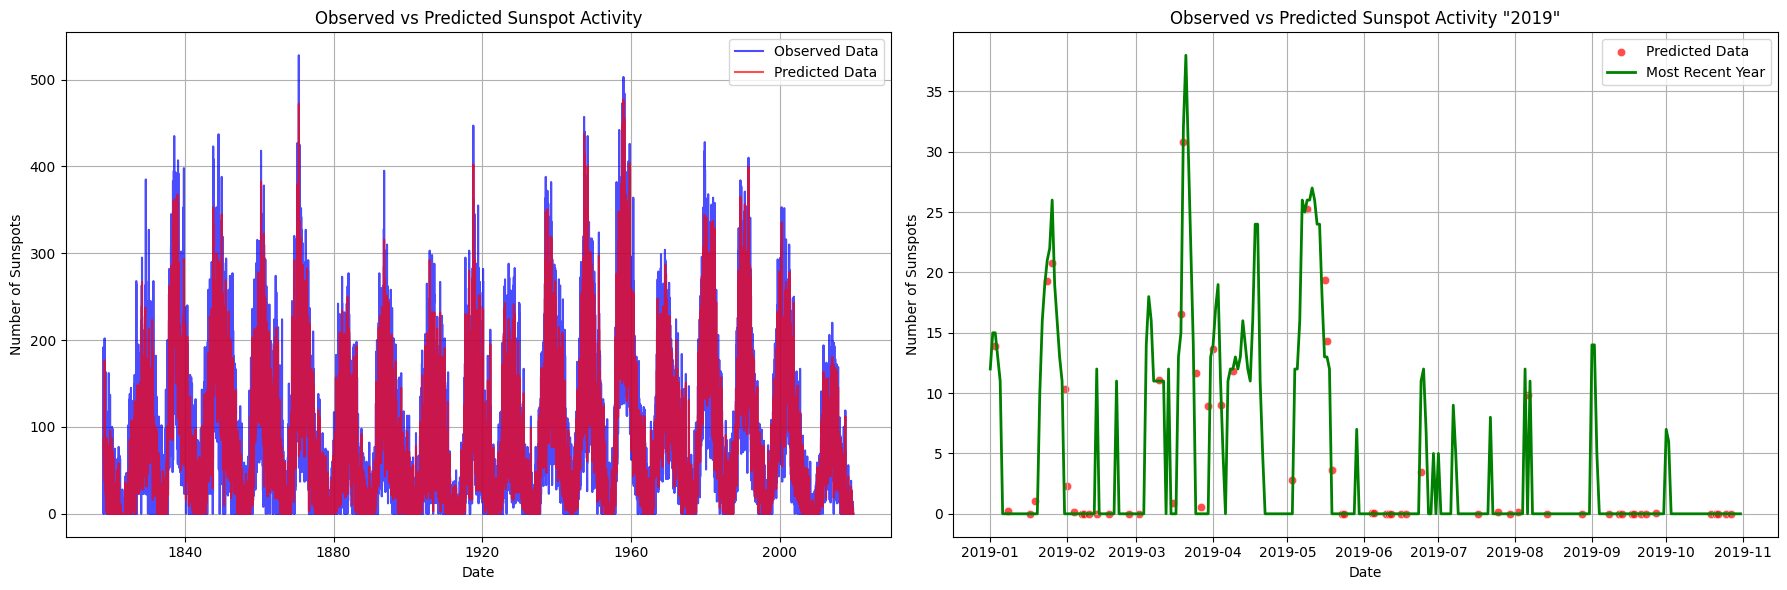

In [20]:
X_test['Predicted Sunspots'] = y_pred
most_recent_year = sunspot_clean['Date'].max().year
recent_data = sunspot_clean[sunspot_clean['Date'].dt.year == most_recent_year]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.lineplot(x=sunspot_clean['Date'], y=sunspot_clean['Number of Sunspots'], color='blue', label='Observed Data', alpha=0.7, ax=axes[0])
sns.lineplot(x=sunspot_clean['Date'], y=X_test['Predicted Sunspots'], color='red', label='Predicted Data', alpha=0.7, ax=axes[0])

axes[0].set_title('Observed vs Predicted Sunspot Activity')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Sunspots')
axes[0].legend()
axes[0].grid(True)

sns.scatterplot(x=recent_data['Date'], y=X_test['Predicted Sunspots'], color='red', label='Predicted Data', alpha=0.7, ax=axes[1])
sns.lineplot(x=recent_data['Date'], y=recent_data['Number of Sunspots'], color='green', label='Most Recent Year', linewidth=2, ax=axes[1])

axes[1].set_title('Observed vs Predicted Sunspot Activity "2019"')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Sunspots')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

As you can see in the above plots, the $R^2$ value is high as the predicted plots are close to accurate. The Mean Squared Error is higher because for each plotted point that is off, its off by a significant amount. 

### Conclusion

Using a Random Forest Regressor was a much better choice and worked quite well for the data we have provided the program. This data set is well filled and produces clean results for a machine learning model to use. The model was able to produce visually appealing graphs. The next steps going forward for a project like this one would be to wait for more data to be collected and continue to run and improve the model. The MSE value is a clear sign that there are systematic errors still being produced and with more information this model has room for improvement.

Thank you for taking the time to look at this project! 